# Introduction to data wrangling using _`pandas`_.

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [3]:
# full path of the 'orders' dataset
orders_file = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/11253d9f443241b3ce5949802966a80de73af1db/data/olist_orders_dataset.csv'

# full path of the 'customer' dataset
cust_file = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/11253d9f443241b3ce5949802966a80de73af1db/data/olist_customers_dataset.csv'


### Read data

In [4]:
orders = pd.read_csv(orders_file)

orders.shape

(99441, 8)

In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
# let's take a look at order_status 

orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

For this exercise, we will use only four columns from this data frame: `order_id`, `customer_id`, `order_status`, `order_purchase_date`. Let's drop the other columns.

In [7]:
# drop unnecessary columns

drop_vars = ['order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

orders = orders.drop(drop_vars, axis=1)

# check column types

orders.dtypes

order_id                    object
customer_id                 object
order_status                object
order_purchase_timestamp    object
dtype: object

### Convert `order_purchase_timestamp` from `object` to `datetime`

In [8]:
# date-time conversion

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

orders.dtypes

order_id                            object
customer_id                         object
order_status                        object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [9]:
# for this exercise, we won't use the time-stamp
# let's convert the order purchase date-timestamps into dates

orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

# view these two columns
orders[['order_purchase_timestamp', 'order_purchase_date']].head()

,order_purchase_timestamp,order_purchase_date
0,2017-10-02 10:56:33,2017-10-02
1,2018-07-24 20:41:37,2018-07-24
2,2018-08-08 08:38:49,2018-08-08
3,2017-11-18 19:28:06,2017-11-18
4,2018-02-13 21:18:39,2018-02-13


### Daily order volumes

In [10]:
# group by order date and count the number of orders (for each date)

order_counts = orders.groupby('order_purchase_date')['order_id'].count()

order_counts.head()

order_purchase_date
2016-09-04    1
2016-09-05    1
2016-09-13    1
2016-09-15    1
2016-10-02    1
Name: order_id, dtype: int64

The `groupby()` function with a summary function like `count()` returns an indexed pandas dataframe. 

_`pandas`_ uses a similar structure like **SQL** for aggregating data. Here's an analogous SQL query:

`CREATE TABLE order_counts as`

`SELECT order_purchase_date, count(order_id)`

`FROM orders`

`GROUP BY order_purchase_date;`

Plot the daily order volume.

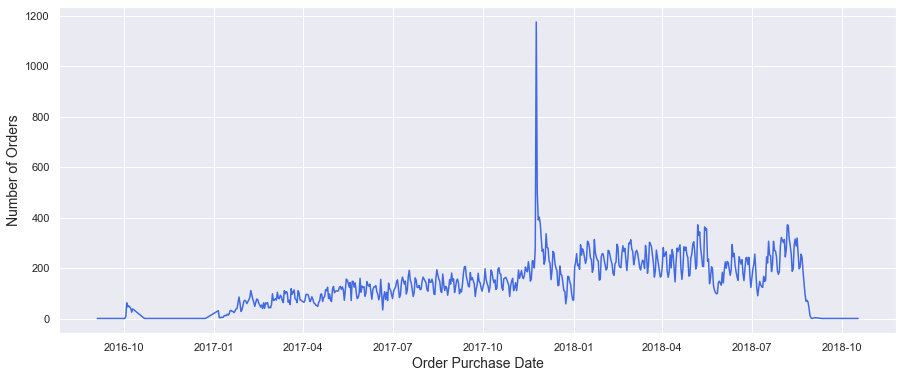

In [11]:
# set style
sns.set(style='darkgrid')

# adjust the plot size
plt.figure(figsize=[15, 6])

# line plot
sns.lineplot(x=order_counts.index, 
             y=order_counts.values, 
             color='royalblue')

# assign axis labels
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Order Purchase Date', fontsize=14);

Some of the recent data seem to be missing or incomplete. Let's take a closer look.

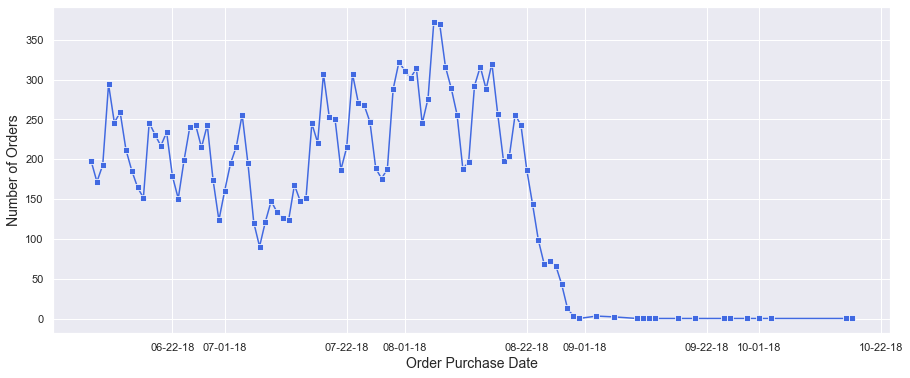

In [15]:
import matplotlib.dates as mdates

# set style
sns.set(style='darkgrid')

# adjust the plot size
fig, ax = plt.subplots(figsize=[15, 6])

# line plot
sns.lineplot(x=order_counts.index[-100:], 
             y=order_counts.values[-100:], 
             marker='s', 
             color='royalblue')

# assign axis labels
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Order Purchase Date', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'));

It appears that perhaps 8/22 is the most recent day with complete data. We should discard the data after that date.

In [17]:
from datetime import date

max_date = date(2018, 8, 22)

# size of the dataset before applying the date filter
print(orders.shape)

# apply the date filter
orders = orders[orders['order_purchase_date'] <= max_date]

# size of the dataset after applying the date filter
print(orders.shape)

(98906, 5)
(98906, 5)


In [18]:
# check
orders.order_purchase_date.max()

datetime.date(2018, 8, 22)

There's a huge spike in the number of orders sometime around November/December 2017. Let's identify that specific day.

In [19]:
# find the date associated with the maximum daily order volume

order_counts[order_counts == max(order_counts)]

order_purchase_date
2017-11-24    1176
Name: order_id, dtype: int64

In [15]:
# let's check the order_status for these orders

orders[orders['order_purchase_date'] == date(2017, 11, 24)]['order_status'].value_counts()

delivered      1147
shipped          12
unavailable      10
invoiced          4
processing        3
Name: order_status, dtype: int64

In [16]:
# let's take a look at the order hour (hour of day) for these orders

orders[orders['order_purchase_date'] == date(2017, 11, 24)]['order_purchase_timestamp'].dt.hour.value_counts(sort=False)

0     55
1     37
2     16
3      5
4      4
5      3
6      9
7     17
8     41
9     55
10    75
11    56
12    64
13    76
14    67
15    68
16    57
17    53
18    49
19    63
20    64
21    77
22    87
23    78
Name: order_purchase_timestamp, dtype: int64

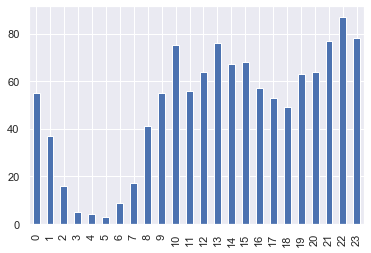

In [17]:
# let's plot it

orders[orders['order_purchase_date'] == date(2017, 11, 24)]['order_purchase_timestamp'].dt.hour.value_counts(sort=False).plot(kind='bar');

This type of finding would be a good opportunity to talk with the business owners to find out the reason(s) behind this anomaly/spike. Here are some potential reasons for this spike: a big one-day sale event (Thanksgiving), big product launch, platform launch (e.g., a new marketplace) on that day.

### Is there a monthly seasonality in the order volumes?

In [18]:
# extract year from the order date

orders['order_year'] = orders['order_purchase_timestamp'].dt.year 

orders['order_year'].value_counts()

2018    53476
2017    45101
2016      329
Name: order_year, dtype: int64

Note: `value_counts()` sorts the results by using the counts in a descending order.

In [19]:
# extract month from the order date

orders['order_month'] = orders['order_purchase_timestamp'].dt.month

orders['order_month'].value_counts(sort=False) / len(orders)

1     0.081583
2     0.086021
3     0.100024
4     0.094463
5     0.106899
6     0.095161
7     0.104321
8     0.104422
9     0.043364
10    0.050098
11    0.076274
12    0.057368
Name: order_month, dtype: float64

In [20]:
# group by year and month to get the number of orders for each combination

orders.groupby(['order_year', 'order_month'])['order_id'].count()

order_year  order_month
2016        9                 4
            10              324
            12                1
2017        1               800
            2              1780
            3              2682
            4              2404
            5              3700
            6              3245
            7              4026
            8              4331
            9              4285
            10             4631
            11             7544
            12             5673
2018        1              7269
            2              6728
            3              7211
            4              6939
            5              6873
            6              6167
            7              6292
            8              5997
Name: order_id, dtype: int64

In [21]:
# reset index to make it a single-index (instead of multi-index) data frame

orders.groupby(['order_year', 'order_month'])['order_id'].count().reset_index().head()

,order_year,order_month,order_id
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780


In [22]:
# save the groupby results in a data frame

order_counts_by_month = orders.groupby(['order_year', 'order_month'])['order_id'].count().reset_index()

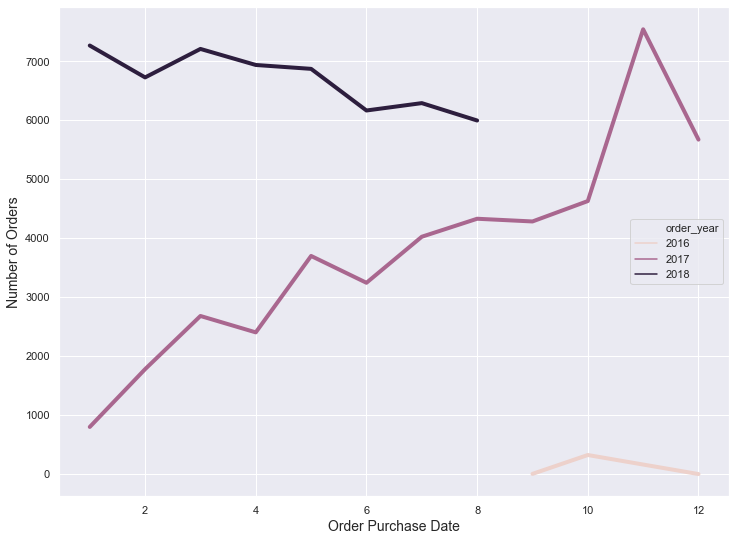

In [23]:
# plot the order volumes by year and month

sns.set(style='darkgrid')

plt.figure(figsize=[12, 9])

sns.lineplot(x='order_month', 
             y='order_id', 
             lw=4,
             hue='order_year', 
             data=order_counts_by_month)

plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Order Purchase Date', fontsize=14);

The data from 2018 in incomplete (available until August), and only three months' worth of data is available from 2017. But based on the available data, there doesn't appear to be any strong seasonality effect over months. 

### Let's take a look at some customer-level patterns

The `customer_id` that's available in the `olist_orders_dataset` file is *not* unique for each customer. The `olist_customers_dataset` file contains the unique identifier for each customer.

In [21]:
# read the file that contains the unique customer identifier

cust = pd.read_csv(cust_file)

cust.shape

(99441, 5)

In [22]:
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [23]:
# let's keep only the following two columns: customer_id, customer_unique_id

cust = cust[['customer_id', 'customer_unique_id']]

Merge the orders dataframe with the customer dataframe to append `customer_unique_id` to the orders data.

In [24]:
# merge orders and cust dataframes

orders = pd.merge(orders, cust, on='customer_id', how='inner')

orders.shape

(98906, 6)

_`pandas`_ uses a similar structure like **SQL** for joining (merging) dataframes. Here's an analogous SQL query:

`CREATE TABLE orders as`

`SELECT a.*, b.*`

`FROM orders as a`

`JOIN cust as b`

`ON a.customer_id = b.customer_id;`

Note that an `inner` join is fine here because customers that are present in one dataframe are all also present in the other dataframe.

In [25]:
# confirm how many unique customer IDs we had in the 'orders' dataset

orders.customer_id.nunique()

98906

In [26]:
# number of orders per customer

orders['customer_unique_id'].value_counts().head()

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
Name: customer_unique_id, dtype: int64

Another approach, to get the order counts by customer, is to use `groupby()`.

In [31]:
# number of orders per customer using groupby

orders.groupby('customer_unique_id').size().head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
dtype: int64

Alternatively, use `orders.groupby('customer_unique_id')['order_id'].count()`.

In [31]:
# save these counts (number of orders) in a new dataframe
cust_orders = orders.groupby('customer_unique_id').size().reset_index()

# rename the size/count column
cust_orders = cust_orders.rename(columns={0:'orders'})

cust_orders.head()

,customer_unique_id,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [32]:
# number of customers by their order volume

cust_orders.orders.value_counts(sort=False)

1     92646
2      2715
3       196
4        30
5         9
6         5
7         3
9         1
17        1
Name: orders, dtype: int64

Most customers ordered only once :(

In [33]:
# % of customers by their order volume

cust_orders['orders'].value_counts() / len(cust_orders)

1     0.969040
2     0.028398
3     0.002050
4     0.000314
5     0.000094
6     0.000052
7     0.000031
17    0.000010
9     0.000010
Name: orders, dtype: float64